Computation of the fixed points of our model under conditions of spatial homogeneity (i.e., with no diffusion term). Since we are interested in the stationary state, we can assume that time goes to infinity. Under this assumption, the damage function no longer contributes to the evolution, resulting in a simplified version of the model.

In [1]:
import numpy as np
import configparser
import math
from scipy.optimize import root #more robust than fsolve (hopefully)
from scipy.linalg import eig
from pyDOE import lhs #for LHS sampling
import random
from mpl_toolkits.mplot3d import Axes3D #for 3D scatter
import matplotlib.pyplot as plt

##################################################################################################################################
####################################extract parameters value from the configuration file##########################################
def extract_values(section_name, config):
    values = []
    if section_name in config:
        for key, value in config[section_name].items():
            values.append(float(value))
    else:
        print(f'Section "{section_name}" is not in the configuration file')
    return values

##################################################################################################################################
#################################################set initial guess: random########################################################
def set_initial_guess(num_samples):
#The ranges are chosen based on the maximum and minimum values
#that the state variables assume in the simulations from the reference paper
    ranges = {
        'H': (0, 4500),
        'C': (0, 450),
        'M': (0, 100000),
        'N': (0, 100),
        'D': (0, 100)
    }

#symbol * is used to unpack the tuples, which are the values from the dictionary "ranges"
    random_values = {
        'H': [random.randint(*ranges['H']) for _ in range(num_samples)],
        'C': [random.randint(*ranges['C']) for _ in range(num_samples)],
        'M': [random.randint(*ranges['M']) for _ in range(num_samples)]
    }

    random_values['N'] = [random.randint(*ranges['N']) for _ in range(num_samples)]
#Generate D such that N + D <= 100
    random_values['D'] = [random.randint(0, min(100 - random_values['N'][i], ranges['D'][1])) for i in range(num_samples)]
#Mass must be conserved: R = 100 - N - D
    random_values['R'] = [100 - random_values['D'][i] - random_values['N'][i] for i in range(num_samples)]

#Combine all variables into the initial_guess list of lists
    initial_guess = [
        [random_values['H'][i], random_values['C'][i], random_values['M'][i], random_values['N'][i], random_values['D'][i], random_values['R'][i]]
        for i in range(num_samples)
    ]

    return initial_guess

##################################################################################################################################
#########################################system of equations in the steady-state form#############################################
def equations(vars, par, H_i, C_i, M_i):
    
    H, C, M, N, D, R = vars
    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = par
    
    eq_H = d_H * H_i + k1 * D * M - d_H * H
    eq_C = d_C * C_i + k2 * D * H - d_C * C
    eq_M = d_M * M_i + k3 * D * M - d_M * M
    eq_N = k4 * R - k5 * C * N    
    eq_D = k5 * C * N - k6 * D * M - d_D * D
#The sixth equation would actually be: eq_R = k6 * D * M + d_D * D - k4 * R
    eq_R = 100 - R - N - D
    
    return [eq_H, eq_C, eq_M, eq_N, eq_D, eq_R]

##################################################################################################################################
#######################################################jacobian matrix############################################################
def jacobian(vars, par, H_i, C_i, M_i):

    H, C, M, N, D, R = vars
    k1, k2, k3, k4, k5, k6, d_H, d_C, d_M, d_D, sigma, m, h = par

#Initialize the Jacobian matrix (6x6 for 6 variables H, C, M, N, D, R)
    J = np.zeros((6, 6))
    
#Partial derivatives of eq_H = d_H * H_i + k1 * D * M - d_H * H
    J[0, 0] = - d_H
    J[0, 2] = k1 * D
    J[0, 4] = k1 * M
    
#Partial derivatives of eq_C = d_C * C_i + k2 * D * H - d_C * C
    J[1, 0] = k2 * D
    J[1, 1] = - d_C
    J[1, 4] = k2 * H
    
#Partial derivatives of eq_M = d_M * M_i + k3 * D * M - d_M * M
    J[2, 2] = k3 * D - d_M
    J[2, 4] = k3 * M
    
#Partial derivatives of eq_N = k4 * R - k5 * C * N 
    J[3, 1] = - k5 * N
    J[3, 3] = - k5 * C
    J[3, 5] = k4
    
#Partial derivatives of eq_D = k5 * C * N - k6 * D * M - d_D * D
    J[4, 1] = k5 * N
    J[4, 2] = - k6 * D
    J[4, 3] = k5 * C
    J[4, 4] = - k6 * M - d_D
    
#Partial derivatives of eq_R = 100 - R - D - N
    J[5, 3] = - 1
    J[5, 4] = - 1
    J[5, 5] = - 1

    return J    

##################################################################################################################################
##################################################################################################################################

##################################################################################################################################
                                                        #SIMULATION
##################################################################################################################################

##################################################################################################################################
##################################################################################################################################

config = configparser.ConfigParser()
config.read('config.ini')

#extract values from the configuration file
i_c = extract_values('initial_conditions_sx', config)
par = extract_values('parameters', config)

H_i, C_i, M_i = i_c[0], i_c[1], i_c[2]

num_samples = int(input('Please insert the number of simulations you want to compute \
with random initial guesses:'))

#Random sampling
initial_guesses = set_initial_guess(num_samples) 

for i in range(num_samples):
    initial_guess = initial_guesses[i]
#Solve the system using the root function of the module optimize in scipy with Jacobian
    solution = root(equations, initial_guess, args=(par, H_i, C_i, M_i), jac=jacobian, method='lm')
    if not solution.success:
        print(f'Solution did not converge: {solution.message}')
    else:
        H, C, M, N, D, R = solution.x
        print(f'Initial guess {initial_guess}\nFixed Points:\nH = {H}, C = {C}, M = {M}, N = {N}, D = {D}, R = {R}\n')
        
        vars = [H, C, M, N, D, R]
#Solve the system using the fixed point as new guess, to verify that it is really a fixed point
        residuals = equations(vars, par, H_i, C_i, M_i)
        residuals = list(map(float, residuals))
        print(f'The residuals when the fixed point is used as initial guess are: {residuals}\n')

#Compute the Jacobian matrix at the fixed point and its eigenvalues
        J = jacobian([H, C, M, N, D, R], par, H_i, C_i, M_i)
        eigenvalues = eig(J)[0]
        print(f'Eigenvalues of the Jacobian: {eigenvalues}\n')

        with open('random_guesses.txt', 'a') as file:
            #file.write(f'initial_guess: {initial_guess}\n')
            #file.write(f'H = {H}, C = {C}, M = {M}, N = {N}, D = {D}, R = {R} \n')
            #file.write(f'eigevalues: {eigenvalues}')
#Stability analysis
            if all(np.real(eigenvalues) < 0):
             #   file.write('STABLE\n\n')
                print(f'The fixed point is stable.\n\n\n')
            else:
              #  file.write('UNSTABLE\n\n')
                print(f'The fixed point is unstable.\n\n\n')       


Please insert the number of simulations you want to compute with random initial guesses: 10


Initial guess [3621, 25, 65410, 58, 26, 16]
Fixed Points:
H = -16.329263840147032, C = -36.53768770833306, M = -12.083262646623677, N = -311.54886888273154, D = 34.75223645382951, R = 376.796632428902

The residuals when the fixed point is used as initial guess are: [-1.7763568394002505e-15, -7.105427357601002e-15, -6.039613253960852e-14, 7.105427357601002e-15, 0.0, 2.842170943040401e-14]

Eigenvalues of the Jacobian: [25.8656119 +0.j         -2.97720617+0.j          0.38851854+0.j
 -0.38642647+0.j         -0.8365514 +0.00640688j -0.8365514 -0.00640688j]

The fixed point is unstable.



Initial guess [758, 0, 90600, 30, 38, 32]
Fixed Points:
H = -16.329263840147032, C = -36.53768770833306, M = -12.083262646623677, N = -311.54886888273154, D = 34.75223645382951, R = 376.796632428902

The residuals when the fixed point is used as initial guess are: [-1.7763568394002505e-15, -7.105427357601002e-15, -6.039613253960852e-14, 7.105427357601002e-15, 0.0, 2.842170943040401e-14]

Eigenvalues of 

A better way to explore the entire phase space is to use algorithms such as Latin Hypercube Sampling. The following cell samples the variables of interest in a predefined subregion of the phase space and then displays the extracted points in reduced 3D space for H, C and M, with different colours depending on which basin of attraction they belong to.

Please insert the number of simulations you want to compute with random initial guesses: 150


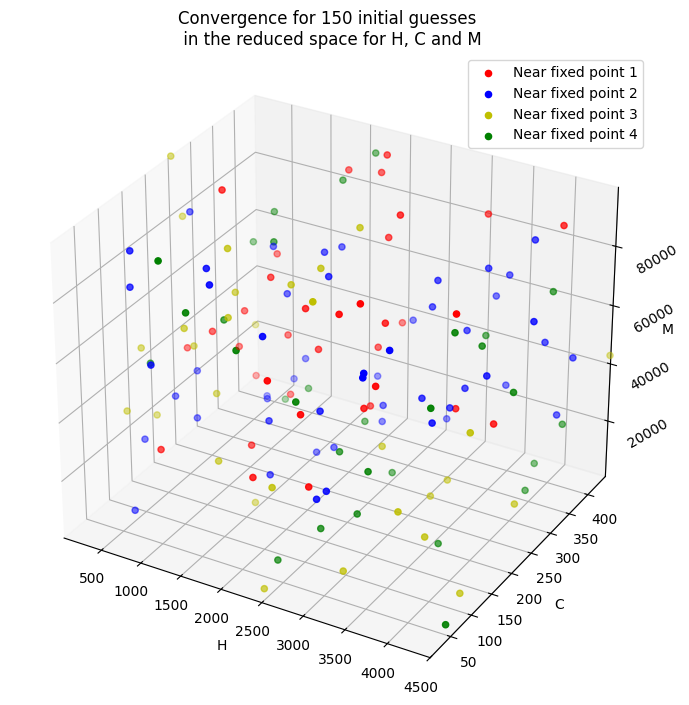

In [3]:
##################################################################################################################################
#################################################Latin Hypercube sampling#########################################################
#LHS is a sampling technique that sistematically explores the phase space
#this is useful when dealing with many dimensions 
def LHS_initial_guess(num_samples):

#Define bounds for variables H, C, M, N; the bound for D is not fixed, it depends on the value of N as D_max = 100 - N
    bounds = np.array([[0, 4500],
                       [0, 450],
                       [0, 100000],
                       [0, 100]])
    min_D = 0.
    min_R = 0.

###############################################################################################################################
#To simulate around a specific fixed point use different bounds:

#fixed_point 1: H = 840.67, C = 64.06, M = 21615.10, N = 31.72, D = 1.00, R = 67.27
    #bounds = np.array([[835, 845],
    #                   [60, 70],
    #                   [21610, 21620],
    #                   [30, 34]])
    
    #min_D = 0.
    #min_R = 66.

#fixed_point 2: H = 30.24, C = 5.36, M = 1163.50, N = 83.62, D = 0.66, R = 15.69
    #bounds = np.array([[28, 32],
    #                   [3, 8],
    #                   [1160, 1167],
    #                   [80, 87]])
    
    #min_D = 0.
    #min_R = 13.5.
    
#fixed_point 3: H = - 16.32, C = - 36.53, M = - 12.08, N = - 311.54, D = 34.75, R = 376.79
    #bounds = np.array([[- 20, - 10],
    #                   [- 40,- 30],
    #                   [- 20,- 5],
    #                   [- 320, - 300]])
    
    #min_D = 30.
    #min_R = 370.

#fixed_point 4: H = - 51.45, C = - 1.07, M = - 901.72, N = 101.53, D = 1.47, R = - 3.01
    #bounds = np.array([[- 55, - 48],
    #                   [- 4, 2],
    #                   [- 910, - 890],
    #                   [99, 103]])
    
    #min_D = 0.5
    #min_R = -5.
###############################################################################################################################

#5 refers to the dimension of the space
#lhs returns a num_samplesX5 matrix of values between 0 and 1, that need to be rescaled according to bounds
    lhs_samples = lhs(5, samples=num_samples)

#Scaling
    scaled_HCMN = bounds[:, 0] + lhs_samples[:,0:4] * (bounds[:, 1] - bounds[:, 0])
    scaled_D = min_D + lhs_samples[:,4] * (100 - scaled_HCMN[:, 3] - min_D - min_R)

#If you want to get integer conditions (not necessary) run the following code
    #integer_HCMN = np.round(scaled_HCMN).astype(int)
    #integer_D = np.round(scaled_D).astype(int)
#Ensure that rounding does not exceed the bounds
    #integer_HCMN = np.clip(integer_HCMN, bounds[:, 0], bounds[:, 1])
    #integer_D = np.clip(integer_D, min_D, scaled_HCMN[:, 3])

    #integer_samples = np.column_stack((integer_HCMN, integer_D))    

#Calculate R as R = 100 - N - D
    #N = integer_samples[:, 3]
    #D = integer_samples[:, 4]
    #R = 100 - N - D
    #R = np.clip(R, 0, 100)

    #initial_guesses = np.column_stack((integer_samples, R))

    #return initial_guesses

#Calculate R as R = 100 - N - D
    R = 100 - scaled_HCMN[:,3] - scaled_D
#and ensure its value does not exceed the range (0, 100)
    R = np.clip(R, 0, 100)
    samples = np.column_stack((scaled_HCMN, scaled_D))

#Append R as the sixth dimension    
    initial_guesses = np.column_stack((samples, R))

    return initial_guesses

##################################################################################################################################
##################################################################################################################################

##################################################################################################################################
                                                        #SIMULATION
##################################################################################################################################

##################################################################################################################################
##################################################################################################################################

num_samples = int(input('Please insert the number of simulations you want to compute \
with random initial guesses:'))

initial_guesses = LHS_initial_guess(num_samples)

#Lists to store the initial guesses and fixed points
initial_H_vals = []
initial_C_vals = []
initial_M_vals = []
initial_N_vals = []
initial_D_vals = []
initial_R_vals = []

fixed_points_H = []
fixed_points_C = []
fixed_points_M = []
fixed_points_N = []
fixed_points_D = []
fixed_points_R = []

for i in range(num_samples):
    initial_guess = initial_guesses[i]

#Storing the initial guesses
    initial_H_vals.append(initial_guess[0])
    initial_C_vals.append(initial_guess[1])
    initial_M_vals.append(initial_guess[2])
    initial_N_vals.append(initial_guess[3])
    initial_D_vals.append(initial_guess[4])
    initial_R_vals.append(initial_guess[5])
    
#Solve the system using the root function with Jacobian
    solution = root(equations, initial_guess, args=(par, H_i, C_i, M_i), jac=jacobian, method='lm')
    if not solution.success:
        print(f'Solution did not converge: {solution.message}')
    else:
        H, C, M, N, D, R = solution.x

        fixed_points_H.append(H)
        fixed_points_C.append(C)
        fixed_points_M.append(M)
        fixed_points_N.append(N)
        fixed_points_D.append(D)
        fixed_points_R.append(R)      

#Convert lists into NumPy arrays for easier processing
initial_H_vals = np.array(initial_H_vals)
initial_C_vals = np.array(initial_C_vals)
initial_M_vals = np.array(initial_M_vals)
initial_N_vals = np.array(initial_N_vals)
initial_D_vals = np.array(initial_D_vals)
initial_R_vals = np.array(initial_R_vals)

fixed_points_H = np.array(fixed_points_H)

#This values were obtaind from previous simulations
fixed_point_H_1 = 840
fixed_point_H_2 = 30
fixed_point_H_3 = -16
fixed_point_H_4 = -51

condition_1 = np.abs(fixed_points_H - fixed_point_H_1) < 1
condition_2 = np.abs(fixed_points_H - fixed_point_H_2) < 1
condition_3 = np.abs(fixed_points_H - fixed_point_H_3) < 1
condition_4 = np.abs(fixed_points_H - fixed_point_H_4) < 1

#Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

#Plot the points based on conditions with different colours
ax.scatter(initial_H_vals[condition_1], initial_C_vals[condition_1], initial_M_vals[condition_1], c='r', marker='o', label='Near fixed point 1')
ax.scatter(initial_H_vals[condition_2], initial_C_vals[condition_2], initial_M_vals[condition_2], c='b', marker='o', label='Near fixed point 2')
ax.scatter(initial_H_vals[condition_3], initial_C_vals[condition_3], initial_M_vals[condition_3], c='y', marker='o', label='Near fixed point 3')
ax.scatter(initial_H_vals[condition_4], initial_C_vals[condition_4], initial_M_vals[condition_4], c='g', marker='o', label='Near fixed point 4')

#Set labels
ax.set_xlabel('H')
ax.set_ylabel('C')
ax.set_zlabel('M')
#ax.set_title(f'Convergence for {num_samples} initial values around (...) \n \
#in the reduced space for variables H, C and M')

ax.set_title(f'Convergence for {num_samples} initial guesses \n in the reduced space for H, C and M')
ax.tick_params(axis='z', pad=10, labelrotation=30)

#Zoom in on the region where the points are
ax.set_xlim([min(initial_H_vals) - 1, max(initial_H_vals) + 1])
ax.set_ylim([min(initial_C_vals) - 1, max(initial_C_vals) + 1])
ax.set_zlim([min(initial_M_vals) - 1, max(initial_M_vals) + 1])

ax.legend()

#Adjust the layout manually to ensure labels aren't cut off
fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)

#Adjust the aspect ratio of the 3D box to make more room for labels
ax.set_box_aspect([1, 0.9, 0.8])

#plt.savefig('phase_space_HCM.png')

plt.show()

Second plot in the reduced 3D space for N, D and R.

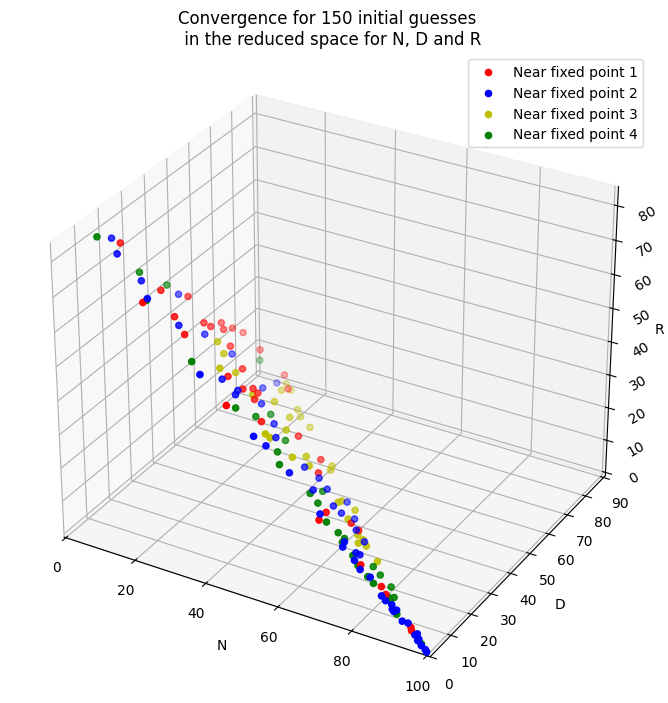

In [4]:
#Create a 3D scatter plot for the other 3 variables
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(initial_N_vals[condition_1], initial_D_vals[condition_1], initial_R_vals[condition_1], c='r', marker='o', label='Near fixed point 1')
ax.scatter(initial_N_vals[condition_2], initial_D_vals[condition_2], initial_R_vals[condition_2], c='b', marker='o', label='Near fixed point 2')
ax.scatter(initial_N_vals[condition_3], initial_D_vals[condition_3], initial_R_vals[condition_3], c='y', marker='o', label='Near fixed point 3')
ax.scatter(initial_N_vals[condition_4], initial_D_vals[condition_4], initial_R_vals[condition_4], c='g', marker='o', label='Near fixed point 4')

ax.set_xlabel('N')
ax.set_ylabel('D')
ax.set_zlabel('R', labelpad=0.5)
#ax.set_title(f'Convergence for {num_samples} initial values around (...) \n \
#in the reduced space for variables N, D and R')
ax.set_title(f'Convergence for {num_samples} initial guesses \n in the reduced space for N, D and R')

ax.tick_params(axis='z', pad=5, labelrotation=30)
ax.legend()

ax.set_xlim([min(initial_N_vals) - 1, max(initial_N_vals) + 1])
ax.set_ylim([0, max(initial_D_vals) + 1])
ax.set_zlim([min(initial_R_vals) - 1, max(initial_R_vals) + 1])

fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
ax.set_box_aspect([1, 0.9, 0.8])

#plt.savefig('phase_space_NDR')

plt.show()

Alternatively, a two-dimensional visualisation can be displayed

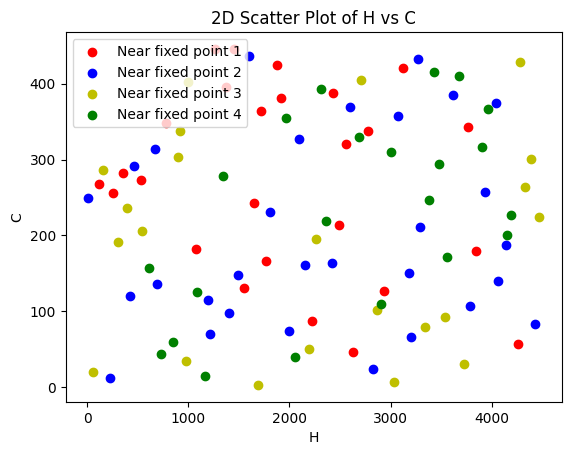

In [190]:
fig, ax = plt.subplots()

#Depending on which variable one is interested in plotting, the initial_*_vals must be modified.
ax.scatter(initial_H_vals[condition_1], initial_C_vals[condition_1], c='r', marker='o', label='Near fixed point 1')
ax.scatter(initial_H_vals[condition_2], initial_C_vals[condition_2], c='b', marker='o', label='Near fixed point 2')
ax.scatter(initial_H_vals[condition_3], initial_C_vals[condition_3], c='y', marker='o', label='Near fixed point 3')
ax.scatter(initial_H_vals[condition_4], initial_C_vals[condition_4], c='g', marker='o', label='Near fixed point 4')

# Set axis labels and title
ax.set_xlabel('H')
ax.set_ylabel('C')
ax.set_title('2D Scatter Plot of H vs C')

# Add a legend
ax.legend()

# Show the plot
plt.show()

The following code allows sampling of only two variables around a specified point in the phase space and visualising the 2D plot.

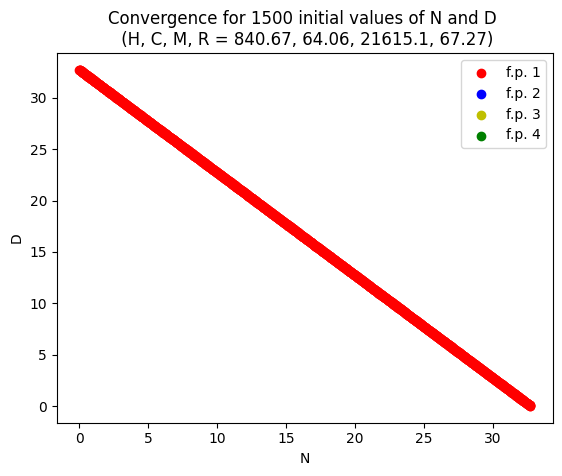

In [192]:
##################################################################################################################################
################################################# Latin Hypercube sampling 2D#####################################################
def LHS_2D_sampling(num_samples, var1, var2, fixed_values):

    all_vars = {'H', 'C', 'M', 'N', 'D', 'R'}
    values_list = list(fixed_values.values())

#Order the variables so that var1 always comes first than var2 in H, C,M, N, D, R
    var_map = {
        'H': 0,
        'C': 1,
        'M': 2,
        'N': 3,
        'D': 4,
        'R': 5
    }

    if var_map[var1] > var_map[var2]:
        var1, var2 = var2, var1
    
#Define bounds for each variable
    bounds = {
        'H': [0, 4500],
        'C': [0, 450],
        'M': [0, 100000],
        'N': [0, 100],
        'D': [0, 100],
        'R': [0, 100]
    }

##################################################################################################################################
#To plot around a specific fixed point use different bounds:

#fixed_point 1: H = 840.67, C = 64.06, M = 21615.10, N = 31.72, D = 1.00, R = 67.27
#    bounds = {
 #       'H': [830, 850],
  #      'C': [62, 66],
   #     'M': [21610, 21630],
    #    'N': [30, 33],
     #   'D': [0, 2],
      #  'R': [65, 70]
    #}

#fixed_point 2: H = 30.24, C = 5.36, M = 1163.50, N = 83.62, D = 0.66, R = 15.69
#    bounds = {
 #       'H': [25, 35],
  #      'C': [2, 8],
   #     'M': [1150, 1170],
    #    'N': [80, 86],
     #   'D': [0, 2],
      #  'R': [13, 18]
    #}

#fixed_point 3: H = - 16.32, C = - 36.53, M = - 12.08, N = - 311.54, D = 34.75, R = 376.79
#    bounds = {
 #       'H': [- 20, - 10],
  #      'C': [- 40, - 30],
   #     'M': [- 20, - 5],
    #    'N': [- 320, - 300],
     #   'D': [30, 40],
      #  'R': [360, 385]
    #}

#fixed_point 4: H = - 51.45, C = - 1.07, M = - 901.72, N = 101.53, D = 1.47, R = - 3.01
#    bounds = {
 #       'H': [- 55, - 48],
  #      'C': [- 3, 1],
   #     'M': [- 910, - 890],
    #    'N': [97, 104],
     #   'D': [0, 3],
      #  'R': [- 6, 0]
    #}
##################################################################################################################################

#Check if var1 and var2 are valid variable names and are different from each other
    if var1 not in bounds or var2 not in bounds:
        raise ValueError(f"Invalid variable names: {var1}, {var2}. Valid names are {list(bounds.keys())}.")
    assert var1 != var2, 'You cannot choose the same variable two times.'

#Perform the check that all 6 variables (H, C, M, N, D, R) are covered
    fixed_keys = set(fixed_values.keys())
    used_vars = fixed_keys.union({var1, var2})
    
    if used_vars != all_vars:
        raise ValueError(f'Your selection does not include all the required variables (H, C, M, N, D, R). Missing variables: {all_vars - used_vars}')
    
#Perform LHS sampling in 2D space for var1 and var2
    lhs_samples = lhs(2, samples=num_samples)

#Extract bounds for the two chosen variables
    var1_bounds = bounds[var1]
    var2_bounds = bounds[var2]

#Rescaling    
#Variables N, D and R must be handled with care because of the constraint N+D+R=100
#when both var1 and var2 are types of fibers we can sample one and the other is then determined
#when only var2 is a fiber its value is fixed
#(since var1 precedes var2, the condition where var1 is in {N, D, R} and var2 is in {H, C, M} cannot occur.)
    if var1 == 'N' and var2 == 'D':
        var1_bounds[1] = min(100 - fixed_values['R'], bounds[var1][1])
        var1_samples = var1_bounds[0] + lhs_samples[:, 0] * (var1_bounds[1] - var1_bounds[0])
        var2_samples = 100 - fixed_values['R'] - var1_samples
    elif var1 == 'N' and var2 == 'R':
        var1_bounds[1] = min(100 - fixed_values['D'], bounds[var1][1])
        var1_samples = var1_bounds[0] + lhs_samples[:, 0] * (var1_bounds[1] - var1_bounds[0])
        var2_samples = 100 - fixed_values['D'] - var1_samples
    elif var1 == 'D' and var2 == 'R':
        var1_bounds[1] = min(100 - fixed_values['N'], bounds[var1][1])
        var1_samples = var1_bounds[0] + lhs_samples[:, 0] * (var1_bounds[1] - var1_bounds[0])
        var2_samples = 100 - fixed_values['N'] - var1_samples            
    elif var1 not in ['N', 'D', 'R'] and var2 in ['N', 'D', 'R']:
#get the 2 fixed variables representing muscle tissue and extract their labels from the dictionary var_map
        value1 = (var_map[var2] + 1) % 3 + 3
        value2 = (var_map[var2] + 2) % 3 + 3
        key1 = next(key for key, val in var_map.items() if val == value1)
        key2 = next(key for key, val in var_map.items() if val == value2)  

        var1_samples = var1_bounds[0] + lhs_samples[:, 0] * (var1_bounds[1] - var1_bounds[0])
        var2_samples = [100 - fixed_values[key1] - fixed_values[key2]] * num_samples
    else:
        var1_samples = var1_bounds[0] + lhs_samples[:, 0] * (var1_bounds[1] - var1_bounds[0])
        var2_samples = var2_bounds[0] + lhs_samples[:, 1] * (var2_bounds[1] - var2_bounds[0])   

#Prepare the array for the final initial guesses with fixed values
    initial_guesses = np.zeros((num_samples, 6))
    
#Assign sampled values to var1 and var2
    initial_guesses[:, var_map[var1]] = var1_samples
    initial_guesses[:, var_map[var2]] = var2_samples
    
#Assign fixed values to the other variables
    for var, value in fixed_values.items():
        if var not in [var1, var2]:
            initial_guesses[:, var_map[var]] = value
    
#Calculate R as usual if N and D are fixed or sampled
    N = initial_guesses[:, var_map['N']]
    D = initial_guesses[:, var_map['D']]
    R = 100 - N - D
    R = np.clip(R, 0, 100)  #ensure R is in range
    initial_guesses[:, var_map['R']] = R

#Append R as the sixth dimension
    initial_guesses[:, 5] = R

    return initial_guesses

##################################################################################################################################
##################################################################################################################################

##################################################################################################################################
                                                        #SIMULATION
##################################################################################################################################

##################################################################################################################################
##################################################################################################################################

all_vars = ['H', 'C', 'M', 'N', 'D', 'R']
var_map = {
    'H': 0,
    'C': 1,
    'M': 2,
    'N': 3, 
    'D': 4, 
    'R': 5
}

#Here you can put the coordinate of the point around which two variables will be sampled 
#Be careful: the central point and the bounds in the sampling function must be consistent.
#If you modify one, remember to modify the other as well.
central_point = [840.67, 64.06, 21615.10, 31.72, 1.00, 67.27] #fixed point 1
#central_point = [30.24, 5.36, 1163.50, 83.62, 0.66, 15.69] #fixed point 2
#central_point = [- 16.32, - 36.53, - 12.08, - 311.54, 34.75, 376.79] #fixed point 3
#central_point = [- 51.45, - 1.07, - 901.72, 101.53, 1.47, - 3.01] #fixed point 4

#Here you can change the number of samples and the variables you want to be sampled
num_samples = 1500
var1, var2 = ['N', 'D']

if var_map[var1] > var_map[var2]:
        var1, var2 = var2, var1
    
remaining_vars = []
for var in all_vars:
    if var != var1 and var != var2:
        remaining_vars.append(var)
        
#Insert the fixed values for the remaining variables
values = []
for var in remaining_vars:
    values.append(central_point[var_map[var]])

#Create a dictionary with the given fixed values associated with the corresponding variable
fixed_values = dict(zip(remaining_vars, values))

#Ensure fixed_values keys are valid and distinct from var1, var2
#fixed_keys = set(fixed_values.keys())    
#Perform the check that all 6 variables (H, C, M, N, D, R) are covered
#used_vars = fixed_keys.union({var1, var2})

#LHS sampling
initial_guesses = LHS_2D_sampling(num_samples, var1, var2, fixed_values)

#Lists to store the initial guesses and fixed points
initial_H_vals = []
initial_C_vals = []
initial_M_vals = []
initial_N_vals = []
initial_D_vals = []
initial_R_vals = []

fixed_points_H = []
fixed_points_C = []
fixed_points_M = []
fixed_points_N = []
fixed_points_D = []
fixed_points_R = []

for i in range(num_samples):
    initial_guess = initial_guesses[i]

#Storing the initial guesses
    initial_H_vals.append(initial_guess[0])
    initial_C_vals.append(initial_guess[1])
    initial_M_vals.append(initial_guess[2])
    initial_N_vals.append(initial_guess[3])
    initial_D_vals.append(initial_guess[4])
    initial_R_vals.append(initial_guess[5])
    
#Solve the system using the root function with Jacobian
    solution = root(equations, initial_guess, args=(par, H_i, C_i, M_i), jac=jacobian, method='lm')
    if not solution.success:
        print(f'Solution did not converge: {solution.message}')
    else:
        H, C, M, N, D, R = solution.x

        fixed_points_H.append(H)
        fixed_points_C.append(C)
        fixed_points_M.append(M)
        fixed_points_N.append(N)
        fixed_points_D.append(D)
        fixed_points_R.append(R)

#Create a dictionary to store the initial values for H, C, M, N, D, R
initial_values = {
    'H': np.array(initial_H_vals),
    'C': np.array(initial_C_vals),
    'M': np.array(initial_M_vals),
    'N': np.array(initial_N_vals),
    'D': np.array(initial_D_vals),
    'R': np.array(initial_R_vals)
}
fixed_points_H = np.array(fixed_points_H)

#Define fixed points for H
fixed_points = [840, 30, -16, -51]

#Create conditions based on proximity to each fixed point
conditions = [np.abs(fixed_points_H - fp) < 1 for fp in fixed_points]

fig, ax = plt.subplots()

#Plot the points based on conditions with different colors
colors = ['r', 'b', 'y', 'g']
labels = [f'f.p. {i+1}' for i in range(len(fixed_points))]
    
for i, condition in enumerate(conditions):
    ax.scatter(initial_values[var1][condition], initial_values[var2][condition], 
                c=colors[i], marker='o', label=labels[i])

ax.set_title(f'Convergence for {num_samples} initial values of {var1} and {var2} \n \
({remaining_vars[0]}, {remaining_vars[1]}, {remaining_vars[2]}, {remaining_vars[3]} \
= {values[0]}, {values[1]}, {values[2]}, {values[3]})')
    
ax.set_xlabel(var1)
ax.set_ylabel(var2)
ax.legend()

#plt.savefig(f'{var1}_{var2}_fp.png')
plt.show()